[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/multimin/blob/master/examples/multimin_asteroids_application.ipynb)

<p align="left"><img src="https://raw.githubusercontent.com/seap-udea/multimin/master/docs/multimin-logo-white.webp" width="600" /></p>

# Asteroid orbital elements: an application of **multimin**

This notebook goes deeper into the **multimin** module: loading data, building CMNDs, and fitting with bounds and multiple components for a particular case, the orbital elements of asteroids.

## Installation

If you're running this in Google Colab or need to install the package, uncomment and run the following cell:

In [23]:
import os
import matplotlib.pyplot as plt
os.makedirs('gallery', exist_ok=True)
try:
    from google.colab import drive
    %pip install -Uq multimin
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2
!mkdir -p gallery/

# Uncomment to install from GitHub (development version)
# !pip install git+https://github.com/seap-udea/MultiMin.git

Welcome to MultiMin v0.9.4. ¡Al infinito y más allá!
Not running in Colab, skipping installation
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the package

Import **multimin** and other required libraries:

In [24]:
import pandas as pd
import numpy as np
import multimin as mn
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

figprefix="asteroids"

## Asteroid data

**multimin** was originally developed to solve the problem of describing the distribution of asteroids in the space of orbital elements. This is a true scientific application of the package that illustrate the power of the methods and the versatility of the numerical methods provided by the package.

Load the dataset (e.g. orbital elements):

In [25]:
# NEA Data
df_neas=pd.read_json(mn.Util.get_data("nea_data.json.gz"))

# Let's filter 10000 asteroids
df_neas=df_neas.sample(10000)

# Let's select the columns we want to fit
df_neas["q"]=df_neas["a"]*(1-df_neas["e"])
data_neas=np.array(df_neas[["q","e","i","Node","Peri","M"]])

Let's see the data:

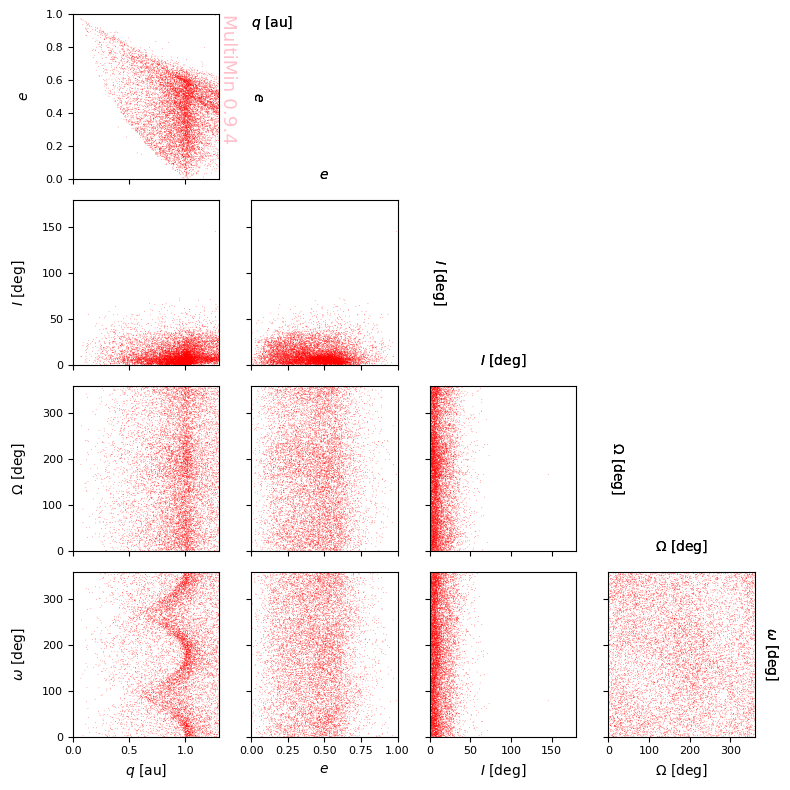

In [26]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
    i=dict(label=r"$I$ [deg]",range=[0.0,180.0]),
    W=dict(label=r"$\Omega$ [deg]",range=[0,360]),
    w=dict(label=r"$\omega$ [deg]",range=[0,360]),
)
G=mn.DensityPlot(properties,figsize=2)

sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.scatter_plot(data_neas,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas.png')


Or a colormesh:

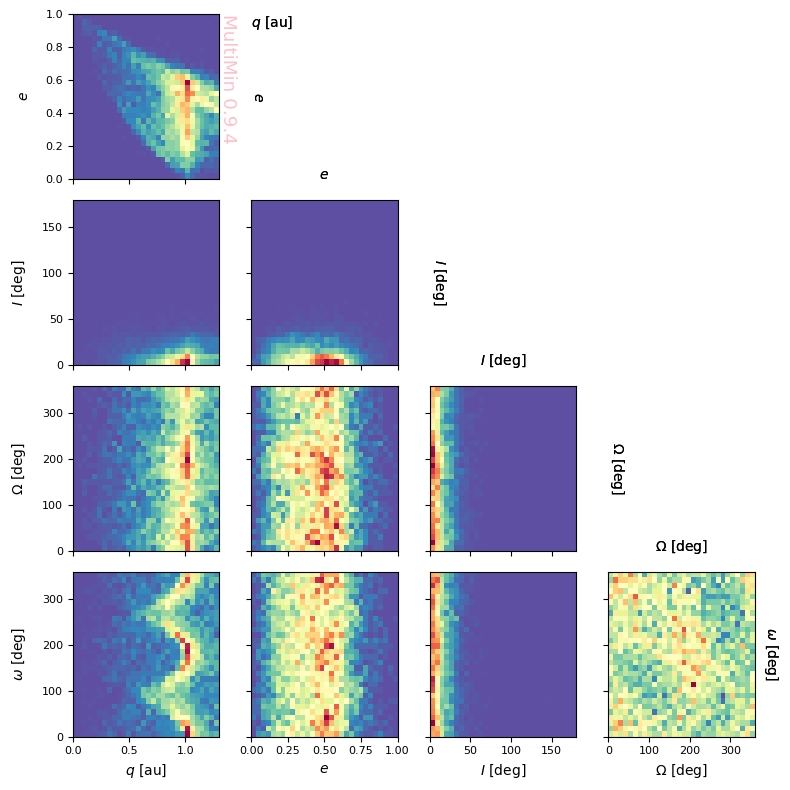

In [27]:
G=mn.DensityPlot(properties,figsize=2)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.plot_hist(data_neas,**hargs)
plt.savefig(f'gallery/{figprefix}_data_neas_hist.png')

### Non-trivially correlated properties

The only elements with a non-trivial distribution are $q, e, I$. Let's study the distribution, for instance, of the $q$ and $e$. For this purpose we need to create a subset:

In [28]:
data_neas_qe=np.array(df_neas[["q","e"]])

And plot it:

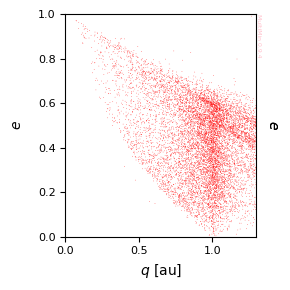

In [29]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)

G=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.scatter_plot(data_neas_qe,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas_qe.png')

Now we will proceed to fit the data against a singled truncated distribution:

In [30]:
t = mn.Util.el_time(0)
F_qe_1 = mn.FitCMND(ngauss=1, nvars=2, domain=[[0,1.3], [0, 1]])
F_qe_1.fit_data(data_neas_qe, advance=0)
t = mn.Util.el_time()
print(f"-log(L)/N = {F_qe_1.solution.fun/len(data_neas_qe)}")

Elapsed time since last call: 111.566 ms
-log(L)/N = -0.09709078263565465


And check the fit result:

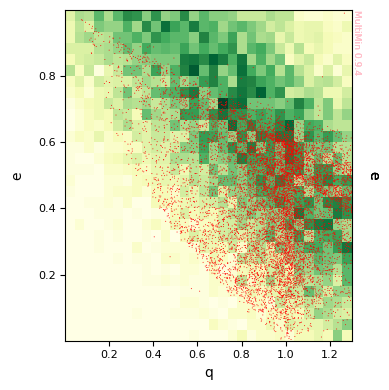

In [31]:
# properties: list of names or dict like DensityPlot (e.g. dict(q=dict(label=r"$q$", range=None), ...))
properties=["q","e"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_qe_1.plot_fit(properties=properties,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_1gauss.png')


In [32]:
F_qe_1.cmnd.tabulate()

,w,mu_1,mu_2,sigma_1,sigma_2,rho_12
component,,,,,,
1,1.0,0.849096,0.65585,1.050962,0.81185,-0.938407


We can do it better increasing the number of normals:

In [33]:
t = mn.Util.el_time(0)
F = mn.FitCMND(ngauss=5, nvars=2, domain=[[0,1.3], [0, 1]])
F.fit_data(data_neas_qe)
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(data_neas_qe)}")

Elapsed time since last call: 24.0256 s
-log(L)/N = -0.7305163164422833


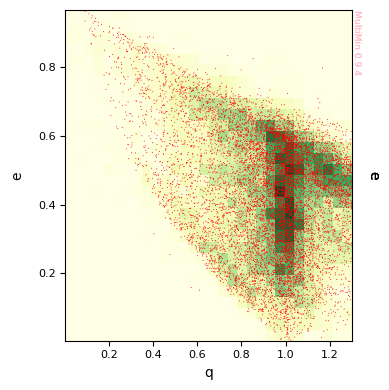

In [34]:
properties=["q","e"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F.plot_fit(
    properties=properties,
    hargs=hargs,
    sargs=sargs,
    figsize=4
)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss.png')

Another way of comparing is to generate a sample with the fitted distribution and compare it with the original one:

In [35]:
neas_sample = F.cmnd.rvs(len(data_neas_qe))

And plot it:

Text(0.5, 1.0, 'Original data')

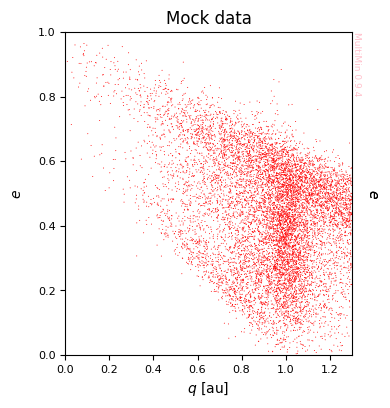

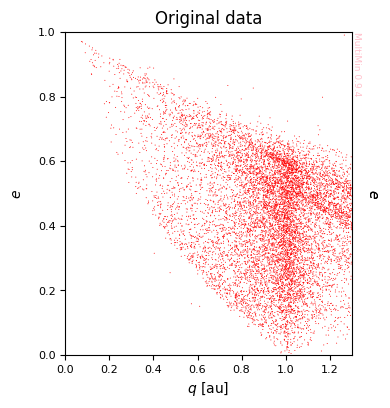

In [36]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
# Mock data
G = mn.DensityPlot(properties,figsize=4)
G.scatter_plot(neas_sample,**sargs)
G.axs[0][0].set_title("Mock data")
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss_sample.png')
# True data
G=mn.DensityPlot(properties,figsize=4)
scatter=G.scatter_plot(data_neas_qe,**sargs)
G.axs[0][0].set_title("Original data")


Let's see the fit function:

In [37]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
table = F.cmnd.tabulate(properties=properties)
table

,w,mu_q,mu_e,sigma_q,sigma_e,rho_qe
component,,,,,,
2,0.359209,0.951318,0.418206,0.270454,0.134933,-0.573320
4,0.298559,1.286299,0.468938,0.471722,0.172631,-0.951722
5,0.161926,1.003155,0.372657,0.048775,0.142384,-0.237981
3,0.126723,0.941643,0.210172,0.137173,0.084765,-0.555706
1,0.053582,0.708998,0.232009,0.175000,0.129539,-0.969946


In [38]:
function, cmnd = F.cmnd.get_function(properties=properties)

import numpy as np
from multimin import tnmd

def cmnd(X):

    a = [0.0, 0.0]
    b = [1.3, 1.0]

    mu1_q = 0.708998
    mu1_e = 0.232009
    mu1 = [mu1_q, mu1_e]
    Sigma1 = [[0.030625, -0.021988], [-0.021988, 0.01678]]
    Z1 = 0.963331
    n1 = tnmd(X, mu1, Sigma1, a, b, Z=Z1)

    mu2_q = 0.951318
    mu2_e = 0.418206
    mu2 = [mu2_q, mu2_e]
    Sigma2 = [[0.073146, -0.020922], [-0.020922, 0.018207]]
    Z2 = 0.900906
    n2 = tnmd(X, mu2, Sigma2, a, b, Z=Z2)

    mu3_q = 0.941643
    mu3_e = 0.210172
    mu3 = [mu3_q, mu3_e]
    Sigma3 = [[0.018817, -0.006461], [-0.006461, 0.007185]]
    Z3 = 0.98963
    n3 = tnmd(X, mu3, Sigma3, a, b, Z=Z3)

    mu4_q = 1.286299
    mu4_e = 0.468938
    mu4 = [mu4_q, mu4_e]
    Sigma4 = [[0.222521, -0.077502], [-0.077502, 0.029801]]
    Z4 = 0.508275
    n4 = tnmd(X, mu4, Sigma4, a, b, Z=Z4)

    mu5_q = 1.003155
    mu5_e = 0.372657
    mu5 = [mu5_q, mu5_e]
    Sigma5 = [[0.002379, -0.001653], [-0.001653, 0.020273]]
    Z5 = 0.995563
    n5

### Fitting other pair of properties

Fitting $q$ and $I$:

-log(L)/N = 3.477621633521375


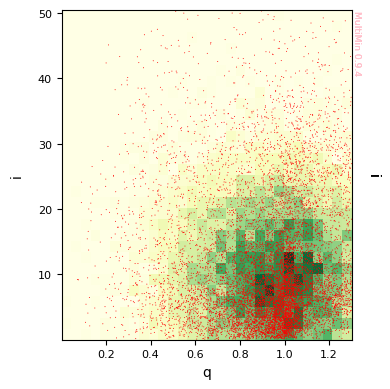

In [39]:
data_neas_qi=np.array(df_neas[["q","i"]])
F_qi_1 = mn.FitCMND(ngauss=1, nvars=2, domain=[[0,1.3], [0, 180]])
F_qi_1.fit_data(data_neas_qi, advance=0)
print(f"-log(L)/N = {F_qi_1.solution.fun/len(data_neas_qi)}")

properties=["q","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_qi_1.plot_fit(properties=properties,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qi_1gauss.png')

Fitting $e$ and $I$:

-log(L)/N = 3.297649820352092


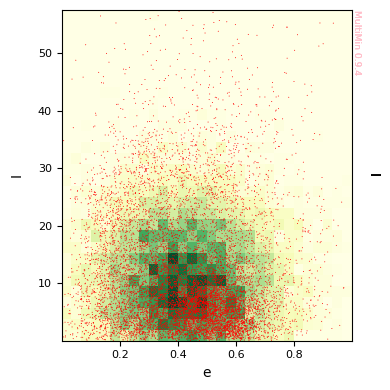

In [40]:
data_neas_ei=np.array(df_neas[["e","i"]])
F_ei_1 = mn.FitCMND(ngauss=1, nvars=2, domain=[[0,1], [0, 180]])
F_ei_1.fit_data(data_neas_ei, advance=0)
print(f"-log(L)/N = {F_ei_1.solution.fun/len(data_neas_ei)}")

properties=["e","I"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_ei_1.plot_fit(properties=properties,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_ei_1gauss.png')

### Fitting three variables: $q, e, I$

Let's extract first the data:

In [41]:
data_neas_qei = np.array(df_neas[["q","e","i"]])

Let's plot the original data:

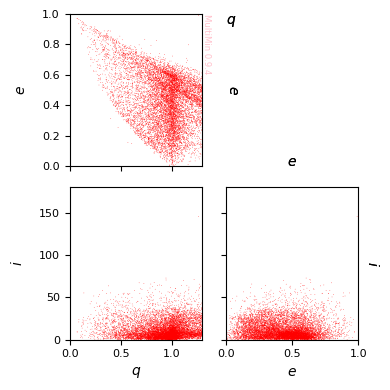

In [42]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

G = mn.DensityPlot(properties, figsize=2)
sargs = dict(s=0.2, edgecolor='None', color='r')
scatter = G.scatter_plot(data_neas_qei, **sargs)
plt.savefig(f'gallery/{figprefix}_data_neas_qei.png')


Now let's try to fit this data using truncated multivariate distribution:

Iterations:
Iter 0:
	Vars: [0.38, 0.5, 0.0028, -2.5, -2.2, -7.5, 1.1, 1.1, 1.1]
	LogL/N: 689.9929404871899
Iter 1:
	Vars: [0.39, 0.5, 0.037, -2.5, -2.2, -7.5, 1.1, 1.2, 0.99]
	LogL/N: 689.6206903537172
Iter 2:
	Vars: [0.38, 0.5, 0.067, -2.5, -2.2, -7.5, 1.1, 1.2, 0.89]
	LogL/N: 689.2312712983586
Iter 3:
	Vars: [0.39, 0.5, 0.062, -2.5, -2.2, -7.5, 1.1, 1.2, 0.9]
	LogL/N: 689.2891117546233
Iter 4:
	Vars: [0.38, 0.5, 0.06, -2.5, -2.2, -7.5, 1.1, 1.2, 0.91]
	LogL/N: 689.3114669838767
Iter 5:
	Vars: [0.38, 0.5, 0.056, -2.5, -2.2, -7.5, 1.1, 1.2, 0.89]
	LogL/N: 689.3275662798357
Iter 6:
	Vars: [0.38, 0.5, 0.05, -2.5, -2.2, -7.4, 1.1, 1.2, 0.84]
	LogL/N: 689.3037576341835
Iter 7:
	Vars: [0.38, 0.5, 0.039, -2.5, -2.2, -7.2, 1.1, 1.3, 0.66]
	LogL/N: 689.1240486223104
Iter 8:
	Vars: [0.36, 0.5, 0.023, -2.5, -2.2, -6.8, 1.1, 1.4, 0.23]
	LogL/N: 688.5226287863012
Iter 9:
	Vars: [0.29, 0.49, 0.012, -2.5, -2.2, -6.3, 1.1, 1.4, -0.083]
	LogL/N: 686.1367670364913
Iter 10:
	Vars: [0.24, 0.49, 0, -2.4, 

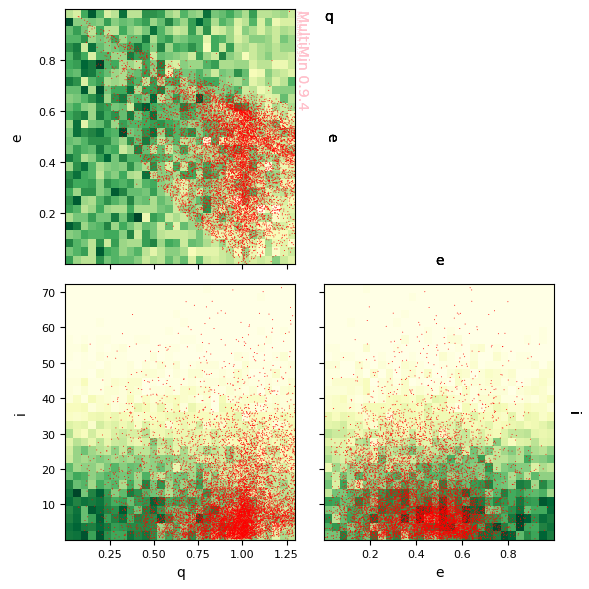

In [43]:
fit_qei = mn.FitCMND(ngauss=1, nvars=3, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.fit_data(data_neas_qei, advance=True, normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

properties=["q","e","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_simple.png')

As you see, without information the fit is not too successful. We will try a different approach.

**Initial parameters from partial fits.** The 1-Gaussian fit in (q,e,i) often misses the q–e correlation when started from generic initial values. We use the three 2D fits (F_qe_1, F_qi_1, F_ei_1) to build initial means, sigmas, and correlations for the full 3D fit: each mean/sigma is averaged over the two partial fits that contain that variable; each correlation comes from the single partial fit that contains that pair.

Iterations:
Iter 0:
	Vars: [0.7, 0.54, 0.048, -2.9, -3, -5.2, -3.4, -0.02, -0.093]
	LogL/N: 673.4689373418215
Iter 1:
	Vars: [0.7, 0.54, 0.048, -2.9, -3, -5.2, -3.4, -0.02, -0.093]
	LogL/N: 673.4689368954766
-log(L)/N = -1.947752067901165


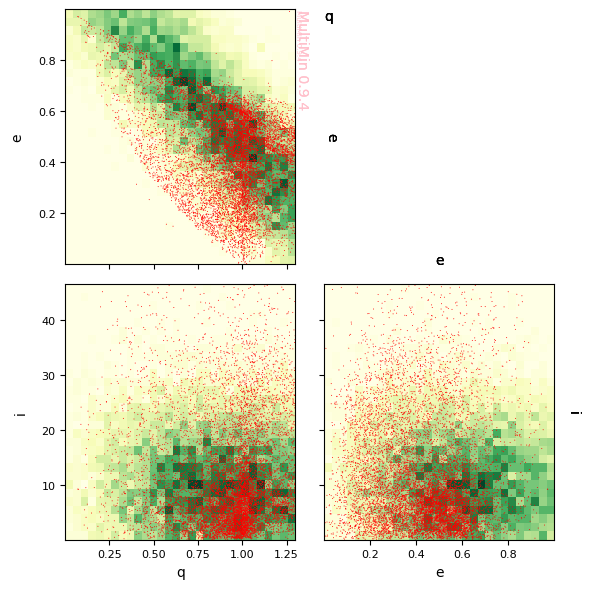

In [44]:
# Initial (mus, sigmas, rhos) from partial fits F_qe_1, F_qi_1, F_ei_1 (vars: 0=q, 1=e, 2=i)
mu_q = (F_qe_1.cmnd.mus[0, 0] + F_qi_1.cmnd.mus[0, 0]) / 2
mu_e = (F_qe_1.cmnd.mus[0, 1] + F_ei_1.cmnd.mus[0, 0]) / 2
mu_i = (F_qi_1.cmnd.mus[0, 1] + F_ei_1.cmnd.mus[0, 1]) / 2
sigma_q = (F_qe_1.cmnd.sigmas[0, 0] + F_qi_1.cmnd.sigmas[0, 0]) / 2
sigma_e = (F_qe_1.cmnd.sigmas[0, 1] + F_ei_1.cmnd.sigmas[0, 0]) / 2
sigma_i = (F_qi_1.cmnd.sigmas[0, 1] + F_ei_1.cmnd.sigmas[0, 1]) / 2
rho_qe = float(F_qe_1.cmnd.rhos[0, 0])
rho_qi = float(F_qi_1.cmnd.rhos[0, 0])
rho_ei = float(F_ei_1.cmnd.rhos[0, 0])

fit_qei = mn.FitCMND(ngauss=1, nvars=3, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)
fit_qei.set_bounds(boundsm=((0.8, 1.2), (0.0, 1.0), (0.0, 15.0)))
fit_qei.fit_data(data_neas_qei, advance=True, normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

properties=["q","e","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_feed.png')

Much better!

Let's try with more gaussians:

Iterations:
Iter 0:
	Vars: [-1.4, -1.4, -1.4, -1.4, -1.4, 0.91, 0.54, 8.6, 0.91, 0.54, 8.6, 0.91, 0.54, 8.6, 0.91, 0.54, 8.6, 0.91, 0.54, 8.6, -2.7, -3, 4.6, -2.7, -3, 4.6, -2.7, -3, 4.6, -2.7, -3, 4.6, -2.7, -3, 4.6, -3.4, -0.02, -0.093, -3.4, -0.02, -0.093, -3.4, -0.02, -0.093, -3.4, -0.02, -0.093, -3.4, -0.02, -0.093]
	LogL/N: 3.507558844069456
Iter 1:
	Vars: [-1.4, -1.4, -1.4, -1.4, -1.4, 0.91, 0.54, 8.6, 0.91, 0.54, 8.6, 0.91, 0.54, 8.6, 0.91, 0.54, 8.6, 0.91, 0.54, 8.6, -2.7, -3, 4.6, -2.7, -3, 4.6, -2.7, -3, 4.6, -2.7, -3, 4.6, -2.7, -3, 4.6, -3.4, -0.02, -0.093, -3.4, -0.02, -0.093, -3.4, -0.02, -0.093, -3.4, -0.02, -0.093, -3.4, -0.02, -0.093]
	LogL/N: 3.5075569899385046
Iter 2:
	Vars: [-1.4, -1.4, -1.4, -1.4, -1.4, 0.91, 0.54, 8.6, 0.91, 0.54, 8.6, 0.91, 0.54, 8.6, 0.91, 0.54, 8.6, 0.91, 0.54, 8.6, -2.7, -3, 4.6, -2.7, -3, 4.6, -2.7, -3, 4.6, -2.7, -3, 4.6, -2.7, -3, 4.6, -3.4, -0.02, -0.093, -3.4, -0.02, -0.093, -3.4, -0.02, -0.093, -3.4, -0.02, -0.093, -3.4, -0.02, -0.093]


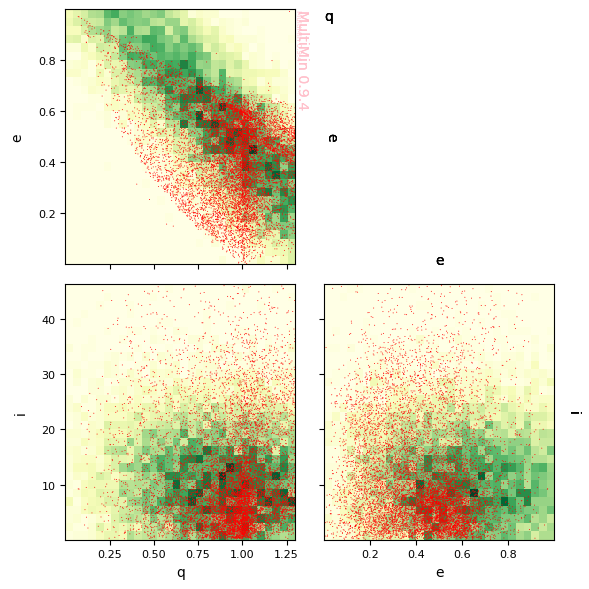

In [45]:
fit_qei = mn.FitCMND(ngauss=5, nvars=3, domain=[[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]])

fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)

fit_qei.fit_data(data_neas_qei, advance=True)
G=fit_qei.plot_fit(
    properties=properties,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_ngauss.png')

The problem is that the fit is not converging to a good representation of the distribution.

### Transforming data

Orbital elements such as $q$, $e$, and $i$ live in **finite intervals** (e.g. $q \in [0, q_{\max}]$, $e \in [0, 1)$, $i \in [0, \pi]$), while the CMND is defined on the whole real line. To fit a normal mixture on unbounded variables we first map each bounded variable to an unbounded one via a **logistic-type (log-odds) transformation** (see e.g. the *manuscript-neoflux* formalism).

For a variable $x \in (0, x_{\max})$, define the **unbound** variable:

$$u = \log\left(\frac{x/x_{\max}}{1 - x/x_{\max}}\right)$$

so that $u \in (-\infty, +\infty)$. The inverse map is:

$$x = \frac{x_{\max}}{1 + \exp(-u)}$$

In the notebook we use this with $q_{\max}=1.35$ au, $e_{\max}=1$, $i_{\max}=\pi$ to obtain unbound variables $(Q, C, I)$. Fitting the CMND in $(Q, C, I)$ and then transforming back preserves normalization and often improves conditioning; the same transformation is used in the manuscript for the NEO flux formalism.

Transform variables to an unbounded scale for fitting (e.g. with `Util.t_if` / `f2u`):

In [46]:
scales=[1.35,1.00,180.0]
udata=np.zeros_like(data_neas_qei)
for i in range(len(data_neas_qei)):
    udata[i]=mn.Util.t_if(data_neas_qei[i],scales,mn.Util.f2u)

Visualize the data with **DensityPlot** (scatter on pairwise panels):

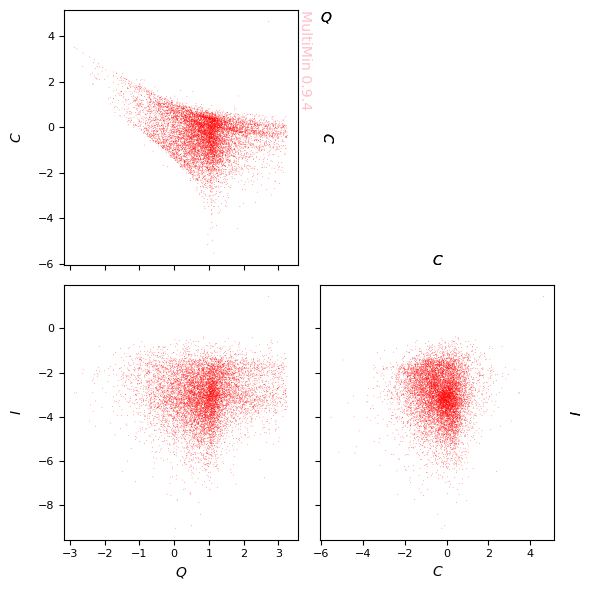

In [47]:
properties=dict(
    Q=dict(label=r"$Q$",range=None),
    E=dict(label=r"$C$",range=None),
    I=dict(label=r"$I$",range=None),
)
G=mn.DensityPlot(properties,figsize=3)

sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.scatter_plot(udata,**sargs)

plt.savefig('gallery/indepth_data_scatter_QCI.png')


The same idea (initial parameters from partial fits) can be reused for multi-component fits below.

You can also show 2D histograms on the panels:

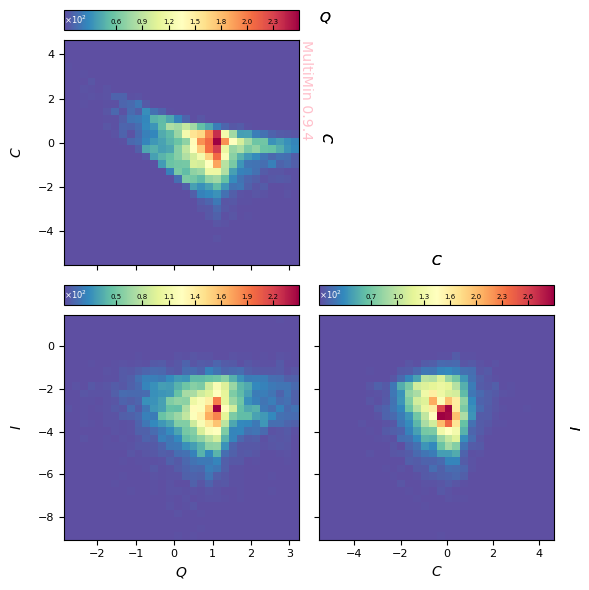

In [48]:
G=mn.DensityPlot(properties,figsize=3)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.plot_hist(udata,colorbar=True,**hargs)

plt.savefig('gallery/multimin_indepth_2.png')


Create the fitter (e.g. one Gaussian, three variables):

In [49]:
F=mn.FitCMND(ngauss=1,nvars=3)

The fitter holds an initial CMND that will be optimized:

In [50]:
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.0, 0.0, 0.0]]
    Standard deviations (σ): [[1.0, 1.0, 1.0]]
    Correlation coefficients (ρ): [[0.0, 0.0, 0.0]]

    Covariant matrices (Σ): 
        [[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]
        With std. and correlations (10):
            [p1,μ1_1,μ1_2,μ1_3,σ1_1,σ1_2,σ1_3,ρ1_12,ρ1_13,ρ1_23]
            [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]


Run the minimization:

In [51]:
t = mn.Util.el_time(0)
F.fit_data(udata,verbose=False,advance=1)
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(udata)}")

Iterations:
Iter 0:
	Vars: [2.3, 1.4, -2, -1.9, -1.7, -1.8, 1.4, 1.1, 1.1]
	LogL/N: 5.27270651359448
Iter 1:
	Vars: [1.8, 0.52, -2.5, -1.8, -1.8, -1.9, 1.1, 1.1, 0.81]
	LogL/N: 4.734056780303161
Iter 2:
	Vars: [0.83, -0.38, -3.1, -2.1, -2.2, -2, -0.034, 0.27, 0.51]
	LogL/N: 4.109154758866767
Iter 3:
	Vars: [0.88, -0.35, -3, -2.4, -2.4, -2.1, -0.62, 0.076, -0.068]
	LogL/N: 3.9672317865347244
Iter 4:
	Vars: [0.88, -0.34, -3, -2.4, -2.4, -2.1, -0.64, 0.09, -0.13]
	LogL/N: 3.9660839721965995
Iter 5:
	Vars: [0.87, -0.33, -3.1, -2.4, -2.4, -2.1, -0.64, 0.09, -0.13]
	LogL/N: 3.9658726718136945
Iter 6:
	Vars: [0.87, -0.33, -3.1, -2.4, -2.4, -2.1, -0.64, 0.09, -0.13]
	LogL/N: 3.9658726718136945
Elapsed time since last call: 150.56 ms
-log(L)/N = 3.9658726718136945


Inspect the fitted CMND:

In [52]:
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8713396429445845, -0.33145949767138455, -3.053712378150718]]
    Standard deviations (σ): [[0.8562971374814939, 0.8568646421268677, 1.0753024288547637]]
    Correlation coefficients (ρ): [[-0.31034046479667676, 0.04490624004430011, -0.06444016619587867]]

    Covariant matrices (Σ): 
        [[[0.7332447876590006, -0.22770633896862477, 0.04134869548776505], [-0.22770633896862477, 0.7342170149272051, -0.05937443650482225], [0.04134869548776505, -0.05937443650482225, 1.156275313500954]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8713396429445845, -0.33145949767138455, -3.053712378150718, 0.7332447876590006, -0.22770633896862477, 0.04134869548776505, 0.7342170149272051, -0.05937443650482225, 1.156275313500954]
        With std. and corre

Plot the fit result (fitted sample + data scatter):

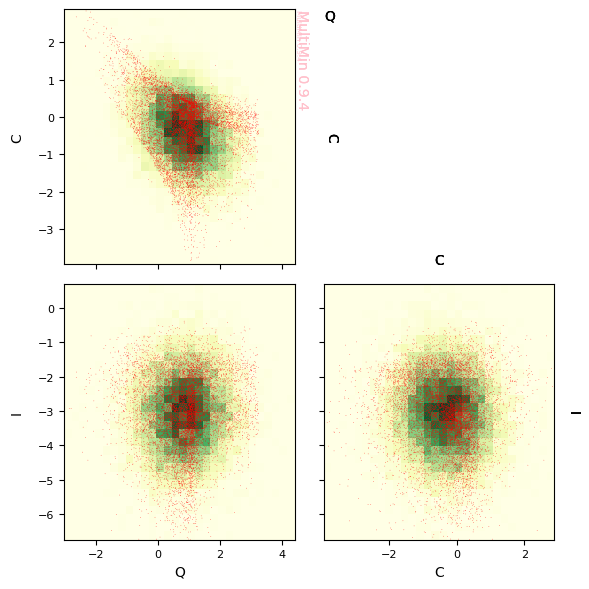

In [53]:
properties=["Q","C","I"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.2,edgecolor='None',color='r')
G=F.plot_fit(properties=properties,hargs=hargs,sargs=sargs,figsize=3)

plt.savefig(f'gallery/{figprefix}_indepth_fit_result_QCI.png')


Fitting can be time-consuming; you can save the result for later use:

In [54]:
F.save_fit(f"gallery/{figprefix}_fit-single.pkl",useprefix=False)

Load a previously saved fit (here or in another notebook):

In [55]:
F=mn.FitCMND(f"gallery/{figprefix}_fit-single.pkl")
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8713396429445845, -0.33145949767138455, -3.053712378150718]]
    Standard deviations (σ): [[0.8562971374814939, 0.8568646421268677, 1.0753024288547637]]
    Correlation coefficients (ρ): [[-0.31034046479667676, 0.04490624004430011, -0.06444016619587867]]

    Covariant matrices (Σ): 
        [[[0.7332447876590006, -0.22770633896862477, 0.04134869548776505], [-0.22770633896862477, 0.7342170149272051, -0.05937443650482225], [0.04134869548776505, -0.05937443650482225, 1.156275313500954]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8713396429445845, -0.33145949767138455, -3.053712378150718, 0.7332447876590006, -0.22770633896862477, 0.04134869548776505, 0.7342170149272051, -0.05937443650482225, 1.156275313500954]
        With std. and corre

Fit with two Gaussian components for a better likelihood:

Iterations:
Iter 0:
	Vars: [0, 0, 2.7, 1.4, -2.1, 1.8, 0.52, -2.3, -1.2, -1.4, -1.6, -2.1, -2.1, -2, 1.5, 1.2, 1.1, 1.3, 1.3, 0.89]
	LogL/N: 4.940458089843229
Iter 5:
	Vars: [-1.4, -0.0029, 0.26, 0.32, -3.3, 1.1, -0.58, -2.9, -2.4, -2.7, -1.9, -2.5, -2.5, -2.3, -1.5, -0.66, 0.38, 0.13, 0.28, -0.098]
	LogL/N: 3.88224240725918
Iter 9:
	Vars: [-1.4, -0.0032, 0.44, 0.42, -3.5, 1, -0.61, -2.9, -2.4, -2.8, -2, -2.5, -2.5, -2.2, -2.1, -0.66, 0.65, -0.00091, 0.23, 0.039]
	LogL/N: 3.8770543854949477
Elapsed time since last call: 849.988 ms
-log(L)/N = 3.8770543854949477
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.28244568036745027, 0.7175543196325497]
    Number of variables: 3
    Averages (μ): [[0.44033969679245316, 0.4233261326376857, -3.496260318764717], [1.0244772485512161, -0.6132800655813407, -2.8870031837670798]]
    Standard deviations (σ): [[0.8667167448517087, 0.566524502163206, 1.2087771596100667], [0.7939978911070057, 0.7705674493

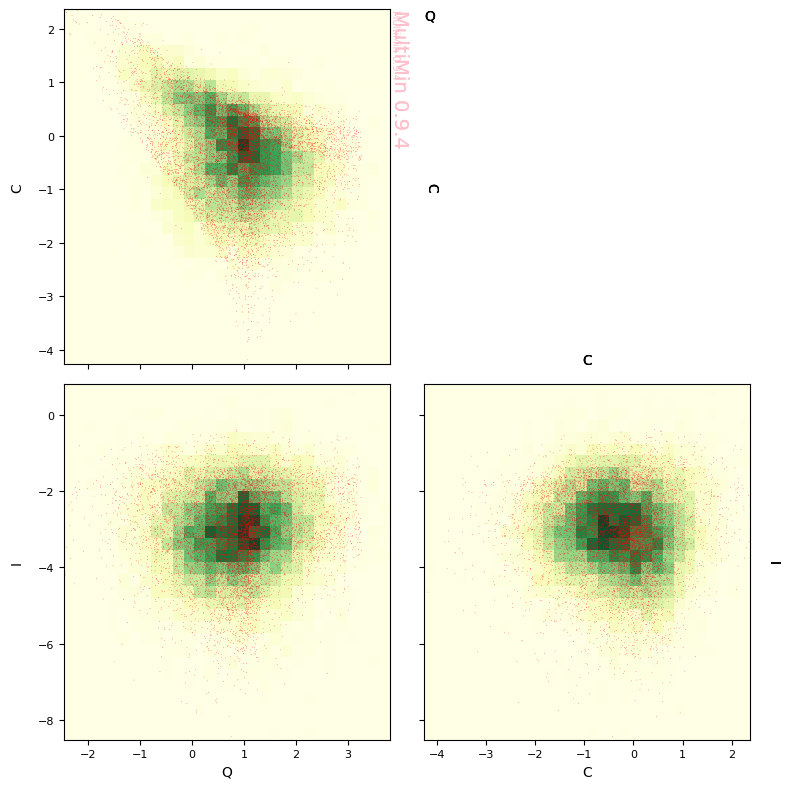

In [56]:
F=mn.FitCMND(ngauss=2,nvars=3)

mn.Util.el_time(0)
F.fit_data(udata,advance=5)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)

G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig(f"gallery/{figprefix}_fit-multiple-{F.prefix}.png")

Using two components improves the fit (lower $-\log\mathcal{L}/N$).

You can set bounds on parameters (e.g. means, weights) to avoid unphysical solutions:

Iterations:
Iter 0:
	Vars: [2.2, 2.2, 2.7, 1.4, -2.1, 1.8, 0.52, -2.3, -1.2, -1.4, -1.6, -2.1, -2.1, -2, 1.5, 1.2, 1.1, 1.3, 1.3, 0.88]
	LogL/N: 4.94135180121727
Iter 5:
	Vars: [-0.52, 2.2, 0.26, 0.31, -3.3, 1.1, -0.59, -2.9, -2.4, -2.7, -1.9, -2.5, -2.5, -2.3, -1.5, -0.65, 0.38, 0.13, 0.28, -0.097]
	LogL/N: 3.882190142592104
Iter 9:
	Vars: [-0.6, 2.2, 0.44, 0.42, -3.5, 1, -0.61, -2.9, -2.4, -2.8, -2, -2.5, -2.5, -2.2, -2.1, -0.66, 0.65, -0.0018, 0.23, 0.039]
	LogL/N: 3.877041465273382
Elapsed time since last call: 963.025 ms
-log(L)/N = 3.877041465273382
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.2827121107835847, 0.7172878892164152]
    Number of variables: 3
    Averages (μ): [[0.4427849535864346, 0.42281728014259556, -3.4956777602850813], [1.0239764445888209, -0.6137323460189203, -2.887019569528201]]
    Standard deviations (σ): [[0.8672906601630563, 0.5661029741484315, 1.2080167384729286], [0.7940935715971261, 0.770517390979234,

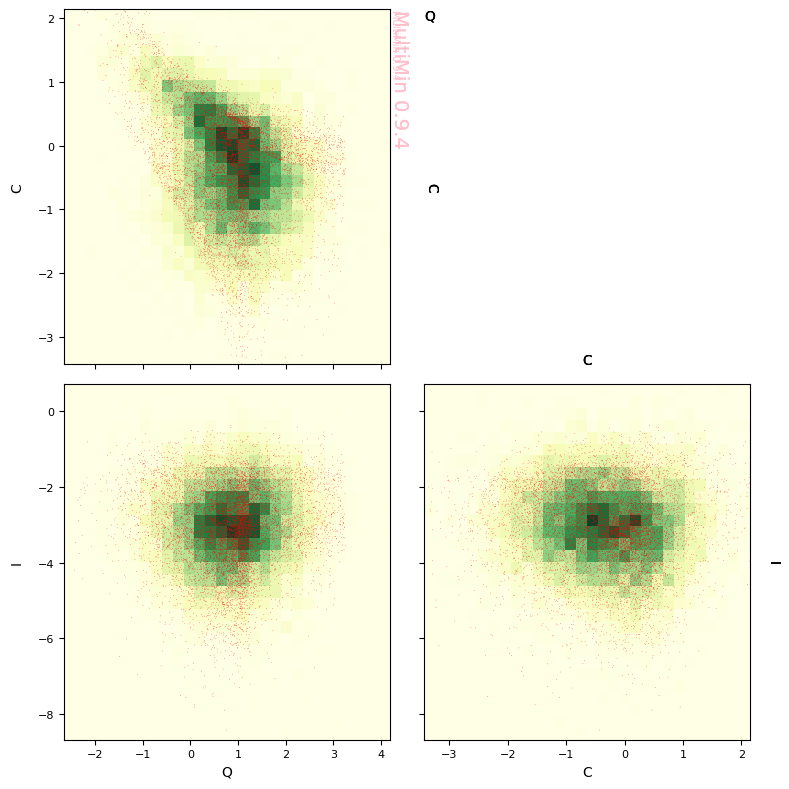

In [57]:
F=mn.FitCMND(ngauss=2,nvars=3)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,advance=5,bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple-bounds.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig("gallery/indepth_fit_2gauss_bounds_QCI.png")

Fitting with five Gaussians can capture more structure:

Iterations:
Iter 0:
	Vars: [2.2, 2.2, 2.2, 2.2, 2.2, 2.9, 1.4, -2.2, 2.7, -0.029, -2.2, 2, 0.2, -2.9, 1.7, 0.29, -2.3, 0.3, 2, -2.1, -1.3, -1.2, -1.3, -1.4, -2.2, -2.5, -2.1, -3.2, -2, -2.3, -2, -2.1, -2.3, -1.3, -2, 2.2, 1.9, 1.2, 2.1, 1.3, 0.71, -0.055, 1.2, 0.72, 1.6, 1.4, 1.1, 0.59, 0.49, 1.2]
	LogL/N: 4.692691912350791
Iter 10:
	Vars: [-2.2, 1.8, 0.76, -0.87, -0.17, 1.1, -1.4, -4.3, 0.94, -0.62, -2.8, 1.2, 0.27, -3.2, 1.4, -0.42, -3.7, -0.16, -0.31, -2.6, -2.8, -2, -1.7, -3.2, -2.7, -2.4, -2.3, -3.2, -2.3, -2.4, -2.7, -1.9, -2.6, -2, -2.3, -0.48, 1.3, -0.68, -0.56, 0.53, -0.33, -2, 0.45, 0.042, -0.93, 1.6, -1.1, -2.5, -0.077, 0.27]
	LogL/N: 3.729157990505544
Iter 20:
	Vars: [-1.6, -0.39, 0.22, -0.75, -0.02, 0.96, -1.1, -4.1, 0.98, -0.37, -2.9, 1.2, 0.25, -3.2, 1.2, -0.73, -3.2, 0.067, -0.4, -2.5, -3.5, -2.2, -1.8, -3.4, -3, -2.4, -2.3, -3.3, -2.2, -2.4, -2.6, -2.1, -2.5, -2.1, -2.4, -0.13, 0.9, -0.6, -0.87, 0.58, -0.82, -1.9, 0.47, 0.011, -0.54, 1.3, -0.75, -2.2, -0.0011, 0.17]
	L

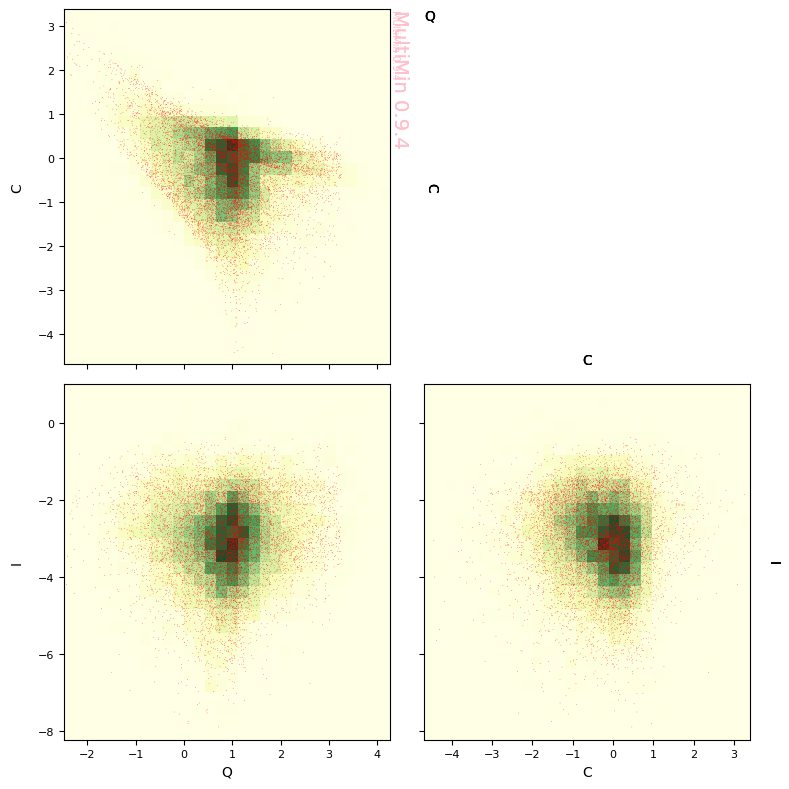

In [58]:
F=mn.FitCMND(ngauss=5,nvars=3)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,advance=10,bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/fit-multiple-bound_mus.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig(f"gallery/{figprefix}_fit_5gauss_bound_mus_QCI.png")

As you can see the fitting parameter $-\log{\cal L}$ is improved with respect to previous fit. 

Verify the fit by generating a sample from the fitted CMND and comparing to the data:

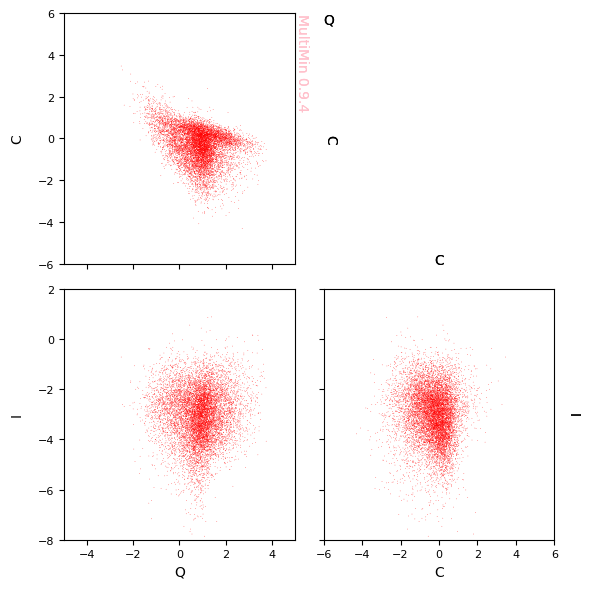

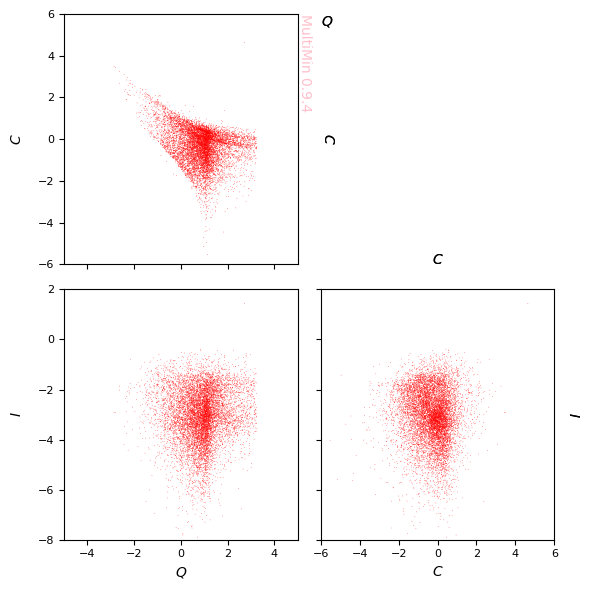

In [ ]:
F.cmnd.plot_sample(N=len(F.data),
                  figsize=3,
                  properties=["Q","C","I"],ranges=[[-5,5],[-6,6],[-8,2]],
                  sargs=dict(s=0.2,edgecolor='None',color='r'))
G.fig.savefig(f"gallery/{figprefix}_sample_from_fit_20gauss_QCI.png")

properties=dict(
    Q=dict(label=r"$Q$",range=[-5,5]),
    C=dict(label=r"$C$",range=[-6,6]),
    I=dict(label=r"$I$",range=[-8,2]),
)
G=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.scatter_plot(udata,**sargs)

We can also check the original distribution:

In [65]:
scales=[1.35,1.00,180.0]
usample = F.cmnd.rvs(len(udata))
rsample=np.zeros_like(usample)
for i in range(len(usample)):
    rsample[i] = mn.Util.t_if(usample[i], scales, mn.Util.u2f)

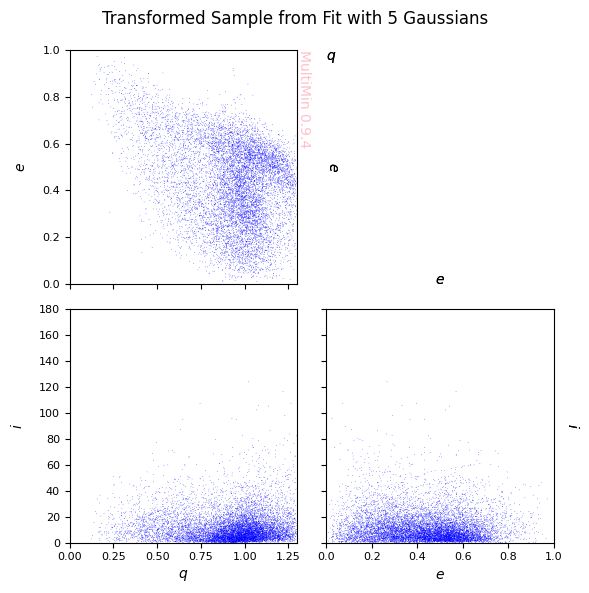

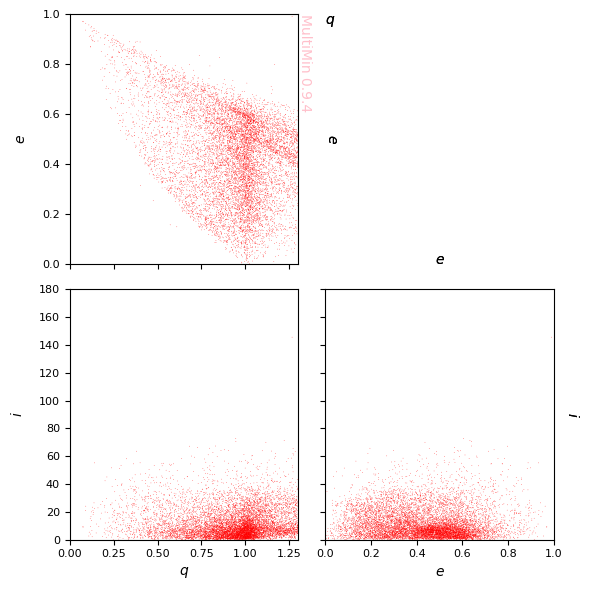

In [79]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

Gt=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='b')
scatter_transformed=Gt.scatter_plot(rsample,**sargs)
Gt.fig.suptitle(f"Transformed Sample from Fit with {F.ngauss} Gaussians")
Gt.fig.tight_layout()
Gt.fig.savefig(f"gallery/{figprefix}_sample_from_fit_ngauss_qei.png")

Go=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter_original=Go.scatter_plot(data_neas_qei,**sargs)

In [80]:
function, cmnd = F.cmnd.get_function(properties=properties)

from multimin import nmd

def cmnd(X):

    mu1_q = 0.958549
    mu1_e = -1.079231
    mu1_i = -4.124616
    mu1 = [mu1_q, mu1_e, mu1_i]
    Sigma1 = [[0.091881, -0.020866, 0.178873], [-0.020866, 1.052208, -0.416728], [0.178873, -0.416728, 1.951705]]
    n1 = nmd(X, mu1, Sigma1)

    mu2_q = 0.982394
    mu2_e = -0.366731
    mu2_i = -2.865159
    mu2 = [mu2_q, mu2_e, mu2_i]
    Sigma2 = [[0.104286, -0.065324, 0.076761], [-0.065324, 0.243582, -0.160263], [0.076761, -0.160263, 0.70419]]
    n2 = nmd(X, mu2, Sigma2)

    mu3_q = 1.231996
    mu3_e = 0.25013
    mu3_i = -3.24596
    mu3 = [mu3_q, mu3_e, mu3_i]
    Sigma3 = [[0.798204, -0.242188, 0.203059], [-0.242188, 0.133363, 0.001963], [0.203059, 0.001963, 0.97106]]
    n3 = nmd(X, mu3, Sigma3)

    mu4_q = 1.203474
    mu4_e = -0.732658
    mu4_i = -3.211416
    mu4 = [mu4_q, mu4_e, mu4_i]
    Sigma4 = [[0.702139, -0.147202, 0.535516], [-0.147202, 0.44615, -0.272029], [0.535516, -0.272029, 1.276487]]
    n4 = nmd(X, mu4, Sigma4)

    

---

**MultiMin** - Multivariate Gaussian fitting

© 2026 Jorge I. Zuluaga